# Práctico VAE (Variational AutoEncoders)

El objetivo de este práctico es explorar las Variational Autoencoders tanto en su implementación como sus bases teóricas.

In [22]:
import torch
import torchinfo
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

### Dataset

In [23]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

Running on cuda


In [24]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [25]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [26]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1*28*28).to(DEVICE)
flatten_batch.shape

torch.Size([100, 784])

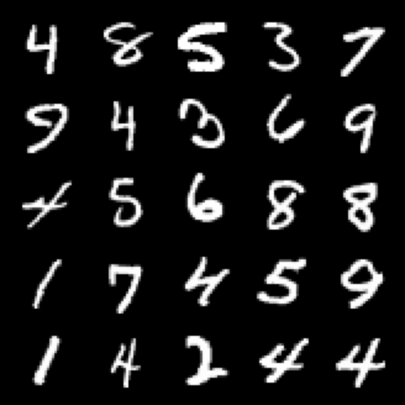

In [27]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

### Modelo VAE

In [28]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=200, latent_dim=2, device=DEVICE): #ignorar z_dim
        super(VAE, self).__init__()

        self.latent_dim = latent_dim 
        # Hiperparametro latent_dim: Dimensionalidad del espacio latente, probarla primero en 2, despues poder probar con mas
    

        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim * latent_dim)
        self.chol_layer = nn.Linear(hidden_dim, latent_dim * latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        # TODO: Completar esta sección. Debes codificar 'x' usando la capa encoder
        # computar la media y la varianza de la distribución latente.
        # Devuelve la media y varianza
        encoded = self.encoder(x)
        mean = self.mean_layer(encoded)
        # Reshape a matriz y construir triangular inferior (Cholesky)
        chol_params = self.chol_layer(encoded)
        chol_params = chol_params.view(-1, self.latent_dim, self.latent_dim)
        # Forzar triangular inferior con diagonal positiva (usar softplus en diagonal)
        L = torch.tril(chol_params)
        # Asegurar diagonal positiva para que sea válida
        diag_idx = torch.arange(self.latent_dim)
        L[:, diag_idx, diag_idx] = torch.nn.functional.softplus(L[:, diag_idx, diag_idx]) + 1e-6
        return mean, L

    def reparameterization(self, mean, L):
        epsilon = torch.randn_like(mean)
        # z = μ + L·ε
        z = mean + torch.bmm(L, epsilon.unsqueeze(-1)).squeeze(-1)
        return z

    def decode(self, z):
        # TODO: Completar esta sección. Usar el decodificador para transformar 'z' 
        #      de nuevo a una representación del espacio original.
        # Devuelve la reconstrucción.
        reconstructed = self.decoder(z)
        return reconstructed

    def forward(self, x):

        mean, L = self.encode(x)
        z = self.reparameterization(mean, L)
        reconstructed = self.decode(z)
        return reconstructed, mean, L
    
    def generate(self, num_samples=1):
        # TODO: Completar esta sección. Generar nuevas muestras a partir de la distribución latente.
        # Devuelve las nuevas muestras generadas.
        z = torch.randn(num_samples, self.latent_dim).to(self.device)
        samples = self.decode(z)
        return samples

In [29]:
LR = 1e-3

model = VAE(device=DEVICE).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [30]:
torchinfo.summary(model, input_size=(100,784), col_names = ('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                1,604
├─Sequential: 1-1                        [100, 784]                [100, 400]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─ReLU: 2-2                         [100, 400]                [100, 400]                --
│    └─Linear: 2-3                       [100, 400]                [100, 400]                160,400
│    └─ReLU: 2-4                         [100, 400]                [100, 400]                --
├─Linear: 1-2                            [100, 400]                [100, 2]                  802
├─Linear: 1-3                            [100, 400]                [100, 4]                  1,604
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-5

###  Función de Pérdida

In [31]:
def loss_function(x, x_hat, mean, L):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # KL divergence con matriz de covarianza completa
    # KL = 0.5 * (tr(Σ) + μᵀμ - k - log|Σ|)
    # donde Σ = L·Lᵀ y log|Σ| = 2·sum(log(diag(L)))
    trace_cov = torch.sum(L ** 2, dim=(1, 2))  # tr(L·Lᵀ)
    log_det = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2) + 1e-8), dim=1)
    mean_sq = torch.sum(mean ** 2, dim=1)
    k = mean.shape[1]
    KLD = 0.5 * torch.sum(trace_cov + mean_sq - k - log_det)
    return reproduction_loss + KLD

### Entrenamiento

In [32]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [33]:
train(model.to(DEVICE), optimizer, epochs=15, device=DEVICE)

	Epoch 1 	Average Loss:  179.22581607366445
	Epoch 2 	Average Loss:  157.90520967563126
	Epoch 3 	Average Loss:  152.5252348640964
	Epoch 4 	Average Loss:  149.82682173740088
	Epoch 5 	Average Loss:  147.94827205498748
	Epoch 6 	Average Loss:  146.7564159015025
	Epoch 7 	Average Loss:  145.75576289258137
	Epoch 8 	Average Loss:  144.99642062943448
	Epoch 9 	Average Loss:  144.3358458107262
	Epoch 10 	Average Loss:  143.5291258379852
	Epoch 11 	Average Loss:  142.96915868896076
	Epoch 12 	Average Loss:  142.9931391674927
	Epoch 13 	Average Loss:  142.45827644055197
	Epoch 14 	Average Loss:  141.94146903367593
	Epoch 15 	Average Loss:  141.29386612779112


8463502.581054688

### Generación

In [34]:
def generate_digit(z_dim=2):
    x_decoded = model.generate()
    digit = x_decoded.detach().cpu().reshape(28, 28)
    #plt.title(f'[{z_sample[0,0]},{z_sample[0,1]}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

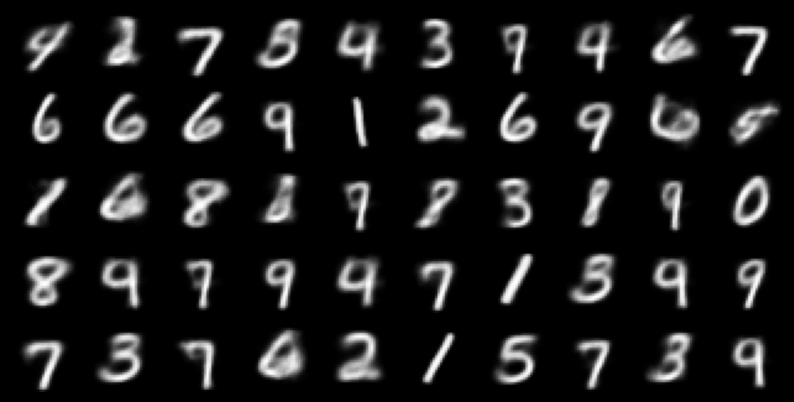

In [35]:
# Generate 50 digits using the VAE
num_generated = 50
generated_images = model.generate(num_samples=num_generated)

# Reshape to 28x28 for visualization
generated_images = generated_images.view(num_generated, 28, 28).detach().cpu()

# Create a grid to display the generated digits
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1)

for ax, img in zip(grid, generated_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()

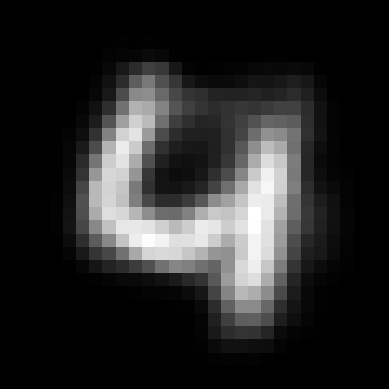

In [36]:
generate_digit()

### Mostrar el espacio latente

In [43]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

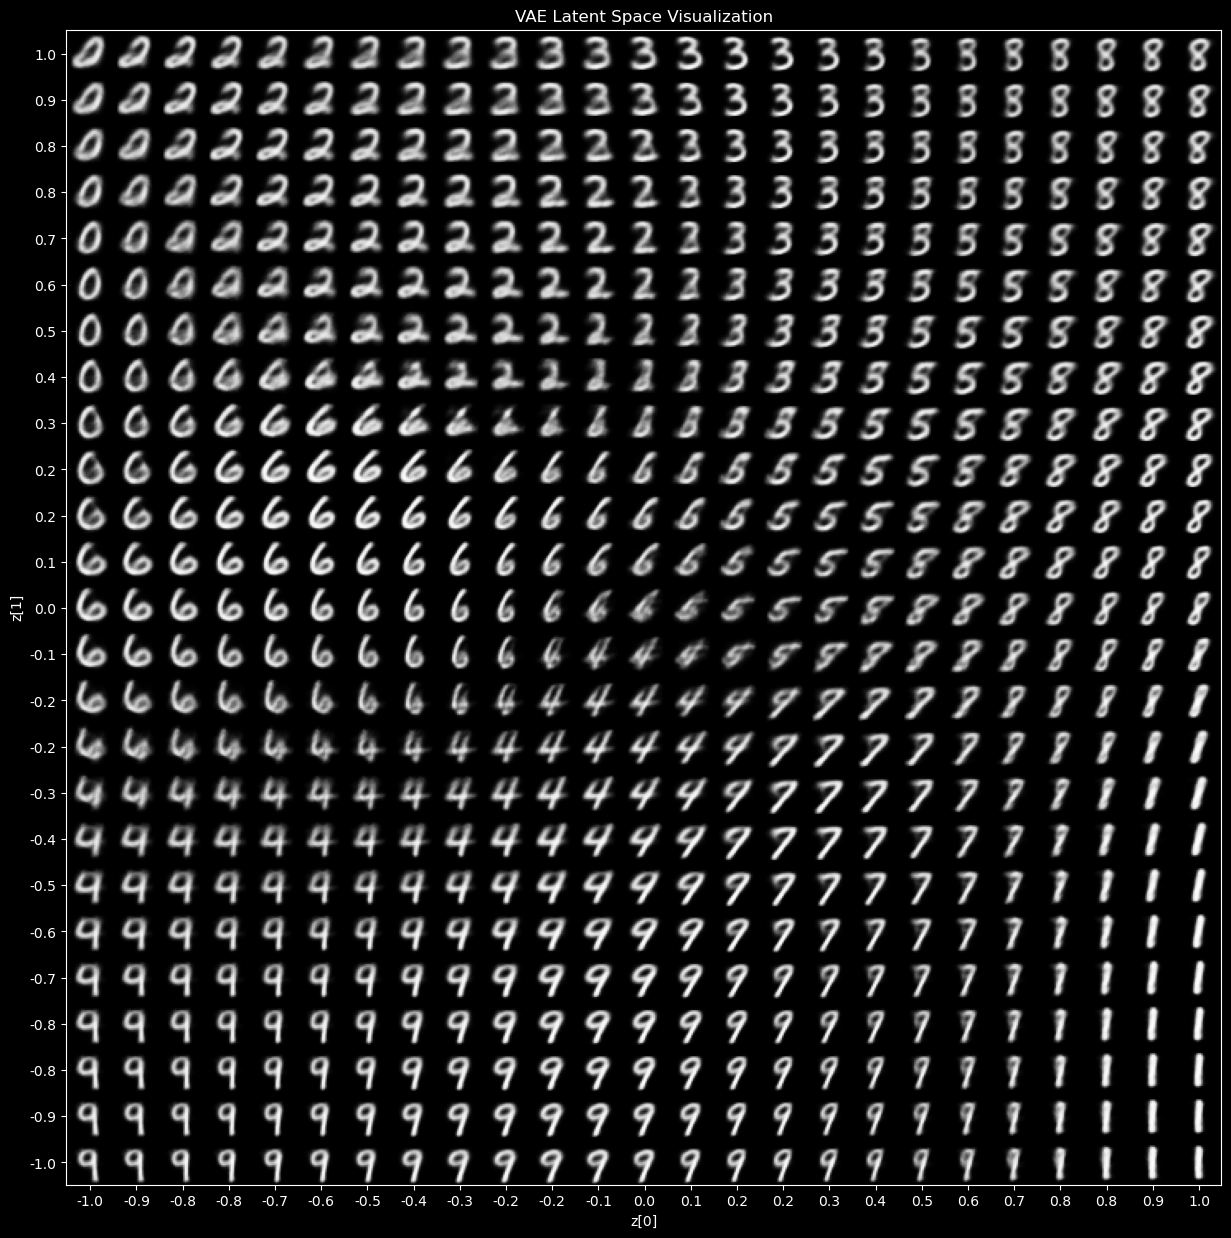

In [44]:
plot_latent_space(model, scale=1)

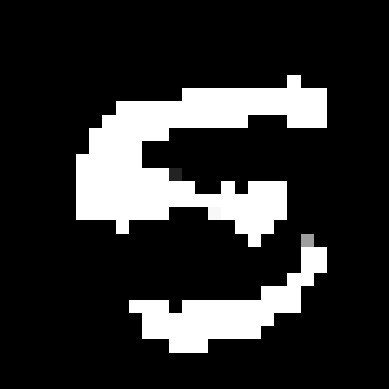

In [84]:
plt.imshow(model.decode(torch.tensor([+140.8,+880.5]).to(DEVICE).unsqueeze(0)).view(28,28).detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

## Ejercicios

1. Complete el código.
2. ¿Por qué es necesario el truco de reparametrización en las VAE?
3. ¿Qué representan las variables mean y var en la VAE?
4. Cree y entrene nuevas VAE modificando los hiperparámetros.
5. ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?
6. ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?
7. Explique que ve en la imágen que se genera cuando llamamos a la función `plot_latent_space`. Si cambiamos la dimensión del espacio latente, ¿qué pasaría con esta gráfica?

### Ejercicio 2: ¿Por qué es necesario el truco de reparametrización en las VAE?

El **truco de reparametrización** es fundamental en las VAE por las siguientes razones:

**Problema sin reparametrización:**
- En una VAE, queremos muestrear de una distribución $q_\phi(z|x) = \mathcal{N}(\mu, \Sigma)$
- El muestreo directo $z \sim \mathcal{N}(\mu, \Sigma)$ es una operación **estocástica**
- Las operaciones estocásticas **no son diferenciables** → no podemos hacer backpropagation a través de ellas
- Sin gradientes, no podemos entrenar el encoder

**Solución con reparametrización:**
- Reescribimos el muestreo como: $z = \mu + L \cdot \epsilon$, donde $\epsilon \sim \mathcal{N}(0, I)$
- $L$ es la descomposición de Cholesky de $\Sigma$
- La aleatoriedad ahora está en $\epsilon$ (que es independiente de los parámetros)
- $\mu$ y $L$ son **determinísticos** dados los parámetros del encoder
- Ahora podemos calcular $\frac{\partial z}{\partial \mu}$ y $\frac{\partial z}{\partial L}$ → **backpropagation funciona**

**En resumen:** Permite entrenar todo el modelo end-to-end con gradiente descendente, moviendo la aleatoriedad fuera del grafo computacional.

### Ejercicio 3: ¿Qué representan las variables mean y var en la VAE?

**`mean` (μ):**
- Representa la **media de la distribución latente** $q_\phi(z|x)$ 
- Es un vector de dimensión `latent_dim` (en nuestro caso, 2)
- Codifica la "ubicación central" de la representación de la imagen en el espacio latente
- Cada dimensión de `mean` captura un aspecto diferente de la variación en los datos
- En nuestro caso con MNIST, podría capturar características como grosor, inclinación, etc.

**`L` (matriz de Cholesky de la covarianza):**
- En nuestra implementación usamos la descomposición de Cholesky $L$ donde $\Sigma = LL^T$
- $\Sigma$ es la **matriz de covarianza** que describe la incertidumbre y correlaciones
- Tiene dimensión `latent_dim × latent_dim` (2×2 en nuestro caso)
- Captura cuánta "dispersión" hay en cada dirección del espacio latente
- **Alta covarianza** → el encoder está menos seguro de la representación
- **Baja covarianza** → el encoder está más confiado

**En la versión diagonal:**
- Si usáramos covarianza diagonal, `logvar` sería un vector de dimensión `latent_dim`
- Cada elemento sería $\log(\sigma_i^2)$ para cada dimensión latente
- Asume independencia entre dimensiones latentes (más simple pero menos expresivo)

**Regularización KL:**
- La divergencia KL empuja estas distribuciones hacia $\mathcal{N}(0, I)$ (gaussiana estándar)
- Esto evita "colapso" y asegura que el espacio latente sea suave y continuo

### Ejercicio 4: Crear y entrenar nuevas VAE modificando los hiperparámetros

Vamos a experimentar con diferentes configuraciones de hiperparámetros para observar cómo afectan el rendimiento:

EXPERIMENTO 1: VAE con latent_dim=10
	Epoch 1 	Average Loss:  174.96548008073353
	Epoch 1 	Average Loss:  174.96548008073353
	Epoch 2 	Average Loss:  131.9542653119783
	Epoch 2 	Average Loss:  131.9542653119783
	Epoch 3 	Average Loss:  124.4070307609036
	Epoch 3 	Average Loss:  124.4070307609036
	Epoch 4 	Average Loss:  120.92577880451795
	Epoch 4 	Average Loss:  120.92577880451795
	Epoch 5 	Average Loss:  118.6424341350167
	Epoch 5 	Average Loss:  118.6424341350167
	Epoch 6 	Average Loss:  117.02197223236644
	Epoch 6 	Average Loss:  117.02197223236644
	Epoch 7 	Average Loss:  115.76990785423622
	Epoch 7 	Average Loss:  115.76990785423622
	Epoch 8 	Average Loss:  114.77774772733201
	Epoch 8 	Average Loss:  114.77774772733201
	Epoch 9 	Average Loss:  113.98851859218489
	Epoch 9 	Average Loss:  113.98851859218489
	Epoch 10 	Average Loss:  113.23658111827004
	Epoch 10 	Average Loss:  113.23658111827004


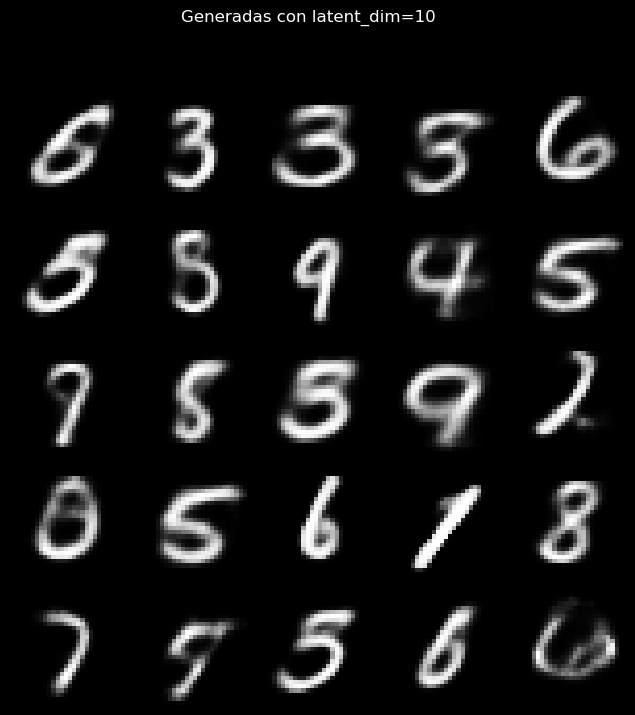

In [89]:
# Experimento 1: VAE con latent_dim = 10 (espacio latente más grande)
print("="*60)
print("EXPERIMENTO 1: VAE con latent_dim=10")
print("="*60)

model_10d = VAE(input_dim=784, hidden_dim=400, latent_dim=10, device=DEVICE).to(DEVICE)
optimizer_10d = Adam(model_10d.parameters(), lr=1e-3)

loss_10d = train(model_10d, optimizer_10d, epochs=10, device=DEVICE, x_dim=784)

# Generar y visualizar
generated_10d = model_10d.generate(num_samples=25).view(25, 28, 28).detach().cpu()
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, img in zip(grid, generated_10d):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generadas con latent_dim=10')
plt.show()

EXPERIMENTO 2: VAE con hidden_dim=800
	Epoch 1 	Average Loss:  172.42939808535058
	Epoch 1 	Average Loss:  172.42939808535058
	Epoch 2 	Average Loss:  153.9192723712698
	Epoch 2 	Average Loss:  153.9192723712698
	Epoch 3 	Average Loss:  149.19140025041736
	Epoch 3 	Average Loss:  149.19140025041736
	Epoch 4 	Average Loss:  146.99798810191464
	Epoch 4 	Average Loss:  146.99798810191464
	Epoch 5 	Average Loss:  145.2100819236488
	Epoch 5 	Average Loss:  145.2100819236488
	Epoch 6 	Average Loss:  144.21146146898477
	Epoch 6 	Average Loss:  144.21146146898477
	Epoch 7 	Average Loss:  143.26076972362793
	Epoch 7 	Average Loss:  143.26076972362793
	Epoch 8 	Average Loss:  142.44863672527129
	Epoch 8 	Average Loss:  142.44863672527129
	Epoch 9 	Average Loss:  141.89743715111123
	Epoch 9 	Average Loss:  141.89743715111123
	Epoch 10 	Average Loss:  141.62817532802066
	Epoch 10 	Average Loss:  141.62817532802066


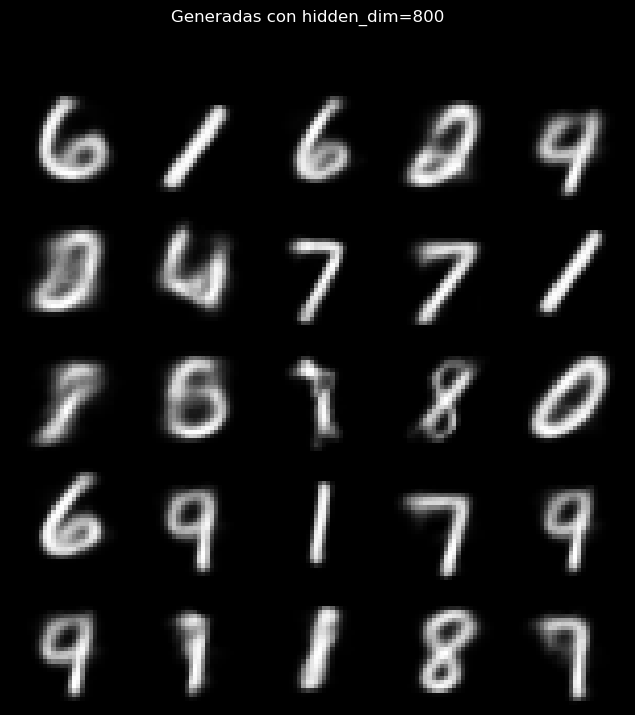

In [90]:
# Experimento 2: VAE con hidden_dim = 800 (red más profunda)
print("="*60)
print("EXPERIMENTO 2: VAE con hidden_dim=800")
print("="*60)

model_deep = VAE(input_dim=784, hidden_dim=800, latent_dim=2, device=DEVICE).to(DEVICE)
optimizer_deep = Adam(model_deep.parameters(), lr=1e-3)

loss_deep = train(model_deep, optimizer_deep, epochs=10, device=DEVICE, x_dim=784)

# Generar y visualizar
generated_deep = model_deep.generate(num_samples=25).view(25, 28, 28).detach().cpu()
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, img in zip(grid, generated_deep):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generadas con hidden_dim=800')
plt.show()

EXPERIMENTO 3: VAE con learning_rate=5e-4
	Epoch 1 	Average Loss:  187.93160009521077
	Epoch 1 	Average Loss:  187.93160009521077
	Epoch 2 	Average Loss:  162.07724950112166
	Epoch 2 	Average Loss:  162.07724950112166
	Epoch 3 	Average Loss:  156.0997633751565
	Epoch 3 	Average Loss:  156.0997633751565
	Epoch 4 	Average Loss:  152.60976947255844
	Epoch 4 	Average Loss:  152.60976947255844
	Epoch 5 	Average Loss:  150.42322901450333
	Epoch 5 	Average Loss:  150.42322901450333
	Epoch 6 	Average Loss:  148.5770100721254
	Epoch 6 	Average Loss:  148.5770100721254
	Epoch 7 	Average Loss:  147.21955997626253
	Epoch 7 	Average Loss:  147.21955997626253
	Epoch 8 	Average Loss:  146.1067610079299
	Epoch 8 	Average Loss:  146.1067610079299
	Epoch 9 	Average Loss:  145.23004230683952
	Epoch 9 	Average Loss:  145.23004230683952
	Epoch 10 	Average Loss:  144.32527702420703
	Epoch 10 	Average Loss:  144.32527702420703


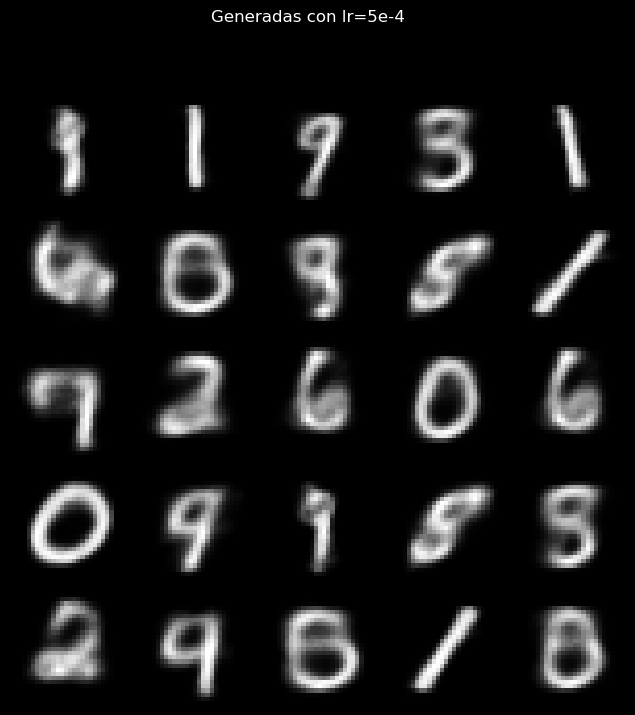

In [91]:
# Experimento 3: VAE con learning rate diferente (lr=5e-4)
print("="*60)
print("EXPERIMENTO 3: VAE con learning_rate=5e-4")
print("="*60)

model_lr = VAE(input_dim=784, hidden_dim=400, latent_dim=2, device=DEVICE).to(DEVICE)
optimizer_lr = Adam(model_lr.parameters(), lr=5e-4)

loss_lr = train(model_lr, optimizer_lr, epochs=10, device=DEVICE, x_dim=784)

# Generar y visualizar
generated_lr = model_lr.generate(num_samples=25).view(25, 28, 28).detach().cpu()
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, img in zip(grid, generated_lr):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Generadas con lr=5e-4')
plt.show()

In [92]:
# Comparación de pérdidas entre modelos
print("\n" + "="*60)
print("COMPARACIÓN DE PÉRDIDAS FINALES")
print("="*60)
print(f"Modelo original (latent_dim=2, hidden=400, lr=1e-3): Loss final promedio")
print(f"Modelo con latent_dim=10: {loss_10d/(len(train_loader)*batch_size):.4f}")
print(f"Modelo con hidden_dim=800: {loss_deep/(len(train_loader)*batch_size):.4f}")
print(f"Modelo con lr=5e-4: {loss_lr/(len(train_loader)*batch_size):.4f}")
print("="*60)


COMPARACIÓN DE PÉRDIDAS FINALES
Modelo original (latent_dim=2, hidden=400, lr=1e-3): Loss final promedio
Modelo con latent_dim=10: 113.0479
Modelo con hidden_dim=800: 141.3921
Modelo con lr=5e-4: 144.0847


### Ejercicio 5: ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?

El tamaño del espacio latente (`latent_dim`) tiene efectos críticos en el rendimiento:

**Espacio latente pequeño (ej. latent_dim=2):**

**Ventajas:**
- ✅ **Visualización fácil:** Podemos graficar directamente en 2D (como vimos con `plot_latent_space`)
- ✅ **Mayor compresión:** Fuerza al modelo a aprender las características más importantes
- ✅ **Menos parámetros:** Entrenamiento más rápido y menos memoria
- ✅ **Regularización implícita:** Evita sobreajuste al tener menos grados de libertad

**Desventajas:**
- ❌ **Pérdida de información:** No puede capturar toda la variabilidad de los datos
- ❌ **Reconstrucciones menos precisas:** Imágenes más borrosas
- ❌ **Bottleneck muy restrictivo:** Puede perder detalles finos

**Espacio latente grande (ej. latent_dim=10, 20, 50):**

**Ventajas:**
- ✅ **Mayor capacidad expresiva:** Puede modelar más variaciones en los datos
- ✅ **Mejores reconstrucciones:** Imágenes generadas más nítidas y precisas
- ✅ **Captura relaciones complejas:** Puede representar más factores de variación

**Desventajas:**
- ❌ **Imposible visualizar:** No podemos graficar espacios de alta dimensión
- ❌ **Riesgo de sobreajuste:** Con muchos grados de libertad puede memorizar
- ❌ **Entrenamiento más lento:** Más parámetros = más cómputo
- ❌ **Menos regularización:** La KL divergence tiene menos efecto relativo
- ❌ **"Curse of dimensionality":** El espacio latente puede volverse disperso

**Trade-off óptimo:**
- Para MNIST (28×28 = 784 píxeles), típicamente `latent_dim` entre 2-20 funciona bien
- `latent_dim=2`: ideal para visualización y entender el modelo
- `latent_dim=10-20`: mejor balance entre calidad y compresión
- `latent_dim > 50`: posiblemente demasiado para MNIST

**Cómo elegir:**
1. Empezar con valores pequeños (2-5) para debugging y visualización
2. Aumentar gradualmente hasta que la pérdida de reconstrucción se estabilice
3. Usar validación cruzada para encontrar el mejor valor
4. Considerar el objetivo: ¿visualización o generación de alta calidad?

### Ejercicio 6: ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?

La **KL-divergence** es uno de los componentes más importantes de la VAE. Analicemos su rol:

**Función de pérdida total:**
$$\mathcal{L} = \underbrace{\text{BCE}(x, \hat{x})}_{\text{Reconstrucción}} + \underbrace{D_{KL}(q_\phi(z|x) \| p(z))}_{\text{Regularización}}$$

**Roles de la KL-divergence:**

**1. Regularización del espacio latente:**
- Empuja la distribución $q_\phi(z|x)$ hacia la prior $p(z) = \mathcal{N}(0, I)$
- Evita que diferentes ejemplos colapsen en regiones separadas del espacio latente
- Asegura que el espacio latente sea **continuo y suave**

**2. Prevención de overfitting:**
- Sin KL: el encoder podría aprender a mapear cada imagen a un punto único
- Con KL: fuerza al encoder a usar distribuciones solapadas
- Actúa como regularización L2 sobre las representaciones latentes

**3. Permite generación:**
- Garantiza que muestrear de $p(z) = \mathcal{N}(0, I)$ produzca códigos válidos
- Sin KL: los puntos aleatorios del espacio latente generarían "basura"
- Con KL: todo el espacio latente contiene representaciones válidas

**4. Balance exploración-explotación:**
- **Fuerza varianza:** Evita que el encoder colapse a $\sigma = 0$ (delta de Dirac)
- **Fuerza media cercana a 0:** Centra las representaciones
- Crea un balance entre certeza en la codificación y generalización

**Fórmula específica (con covarianza completa):**
$$D_{KL} = \frac{1}{2}\left[\text{tr}(\Sigma) + \mu^T\mu - k - \log|\Sigma|\right]$$

Donde:
- $\text{tr}(\Sigma)$ penaliza varianzas grandes
- $\mu^T\mu$ penaliza medias alejadas de cero
- $-k$ es una constante ($k$ = dimensión latente)
- $-\log|\Sigma|$ recompensa varianzas grandes (contrarresta el primer término)

**Efecto del peso de KL:**
- **KL alto** → espacio latente más regular pero reconstrucciones peores (más borrosas)
- **KL bajo** → mejores reconstrucciones pero espacio latente menos útil para generación
- En práctica, se puede usar $\beta$-VAE: $\mathcal{L} = \text{BCE} + \beta \cdot D_{KL}$

**En resumen:** La KL-divergence transforma un simple autoencoder en un modelo generativo, asegurando que el espacio latente tenga estructura útil para generar nuevas muestras válidas.

### Ejercicio 7: Explicar la imagen de `plot_latent_space` y efecto de cambiar dimensión latente

**¿Qué vemos en la visualización del espacio latente?**

La función `plot_latent_space` crea una grilla de 25×25 puntos en el espacio 2D (rango [-scale, +scale]) y decodifica cada punto:

**Observaciones en nuestra VAE con latent_dim=2:**

1. **Continuidad:** Las imágenes cambian suavemente al movernos por el espacio latente
   - No hay "saltos" bruscos entre regiones
   - Esto es efecto de la regularización KL

2. **Clustering de dígitos:** Diferentes regiones contienen diferentes dígitos
   - Ej: una región tiene principalmente "0s", otra "1s", etc.
   - El modelo aprendió a organizar los dígitos en el espacio 2D

3. **Transiciones suaves:** Entre regiones de diferentes dígitos hay "híbridos"
   - Representan interpolaciones entre clases
   - Muestran que el espacio latente es continuo

4. **Regiones de alta densidad:** Las áreas cercanas al centro (0,0) suelen tener dígitos más claros
   - La KL-divergence empuja las medias hacia el origen
   - Los bordes pueden mostrar imágenes más extrañas o mezcladas

5. **Variaciones dentro de cada dígito:** Dentro de la región de un dígito, vemos variaciones
   - Grosor de líneas, inclinación, estilo, etc.
   - El espacio latente captura factores de variación continua

**¿Qué pasaría si cambiamos latent_dim?**

**Si latent_dim = 1 (espacio lineal):**
- ❌ **NO podemos usar `plot_latent_space`** tal como está (espera 2D)
- Podríamos visualizar como una línea 1D de imágenes
- Mucha menos capacidad expresiva, todos los dígitos en una sola línea

**Si latent_dim = 3 o más:**
- ❌ **NO podemos visualizar `plot_latent_space` directamente**
- La función asume exactamente 2 dimensiones (crea grilla 2D)
- Necesitaríamos proyectar a 2D (PCA, t-SNE) o hacer "slices" 2D fijando otras dimensiones
- **Alternativas de visualización:**
  - Mostrar varios "slices" 2D fijando las otras dimensiones en 0
  - Usar reducción de dimensionalidad (t-SNE, UMAP) sobre los códigos latentes
  - Visualizar pares de dimensiones (dim 0 vs dim 1, dim 0 vs dim 2, etc.)
  - Usar visualizaciones interactivas en 3D (si latent_dim=3)

**Veamos un ejemplo modificando la función para visualizar slices:**

Visualizando slice del espacio latente 10D (dimensiones 0 vs 1):


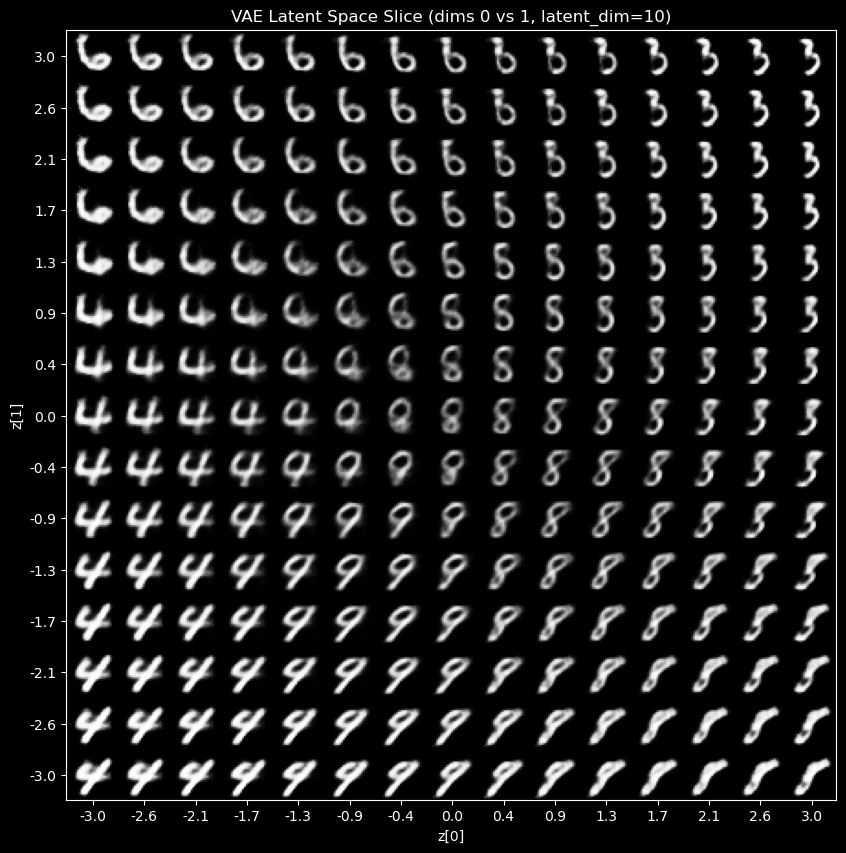

In [95]:
# Función para visualizar "slices" 2D de espacios latentes de mayor dimensión
def plot_latent_space_slice(model, dim1=0, dim2=1, fixed_dims=None, scale=5.0, n=15, digit_size=28, figsize=10):
    """
    Visualiza un slice 2D del espacio latente, útil para latent_dim > 2
    
    Args:
        model: modelo VAE entrenado
        dim1, dim2: dimensiones a variar (ejes x e y)
        fixed_dims: diccionario {dim: valor} para dimensiones fijas, ej. {2: 0.0, 3: 1.5}
        scale: rango [-scale, +scale] para las dimensiones variadas
        n: número de puntos por eje
    """
    if model.latent_dim < 2:
        print("Error: latent_dim debe ser >= 2")
        return
    
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Crear vector latente de dimensión completa
            z_sample = torch.zeros(1, model.latent_dim, dtype=torch.float).to(DEVICE)
            
            # Asignar dimensiones fijas
            if fixed_dims is not None:
                for dim, val in fixed_dims.items():
                    z_sample[0, dim] = val
            
            # Asignar dimensiones variadas
            z_sample[0, dim1] = xi
            z_sample[0, dim2] = yi
            
            # Decodificar
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title(f'VAE Latent Space Slice (dims {dim1} vs {dim2}, latent_dim={model.latent_dim})')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel(f"z[{dim1}]")
    plt.ylabel(f"z[{dim2}]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Ejemplo: visualizar el espacio latente del modelo con latent_dim=10
# Slice de las primeras dos dimensiones, con las demás en 0
print("Visualizando slice del espacio latente 10D (dimensiones 0 vs 1):")
plot_latent_space_slice(model_10d, dim1=0, dim2=1, fixed_dims={i: 0.0 for i in range(2, 10)}, scale=3.0, n=15)


Visualizando otro slice (dimensiones 2 vs 3):


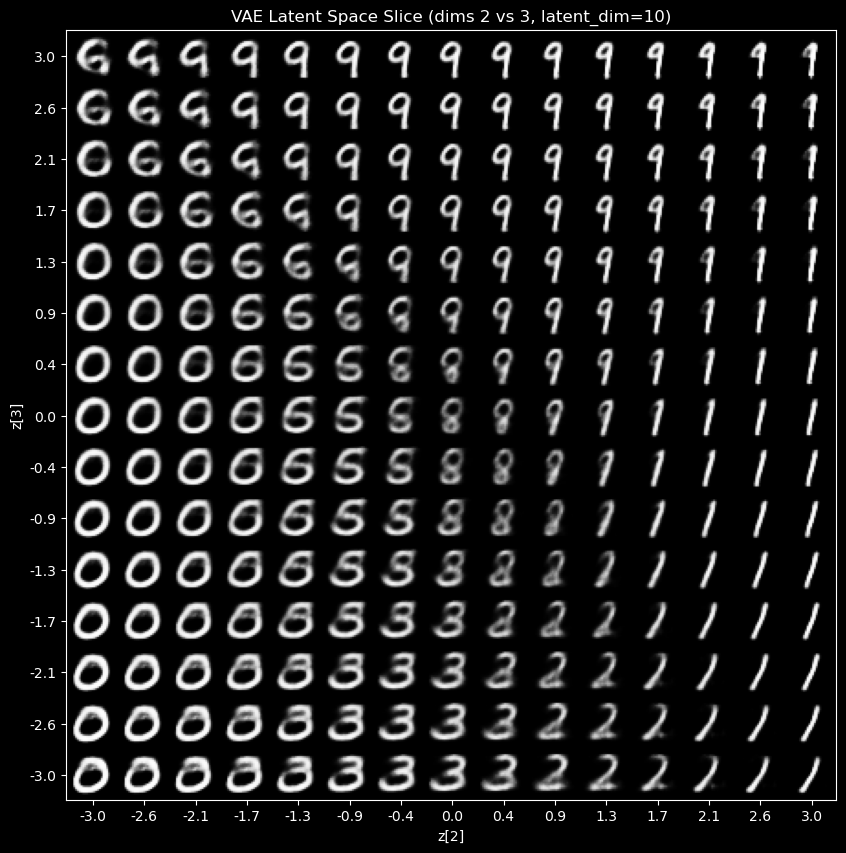

In [96]:
# Visualizar diferentes pares de dimensiones del espacio 10D
print("\nVisualizando otro slice (dimensiones 2 vs 3):")
plot_latent_space_slice(model_10d, dim1=2, dim2=3, fixed_dims={0: 0.0, 1: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}, scale=3.0, n=15)

## Análisis adicional: Interpolación en el espacio latente

Una de las propiedades más interesantes de las VAE es que el espacio latente permite **interpolación suave** entre imágenes:

Interpolación entre dos dígitos del conjunto de test:


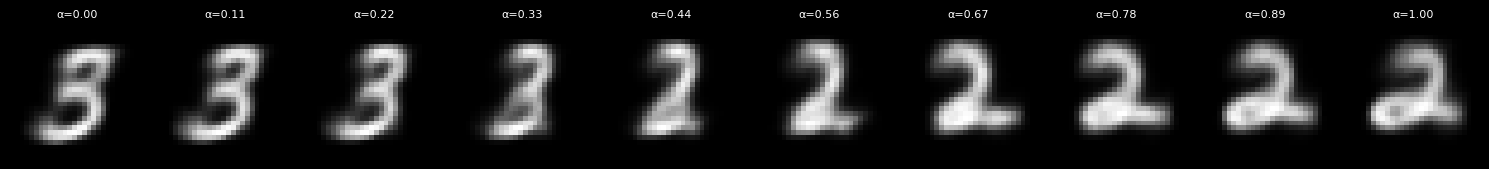


Interpolación entre dos puntos aleatorios del prior N(0,I):


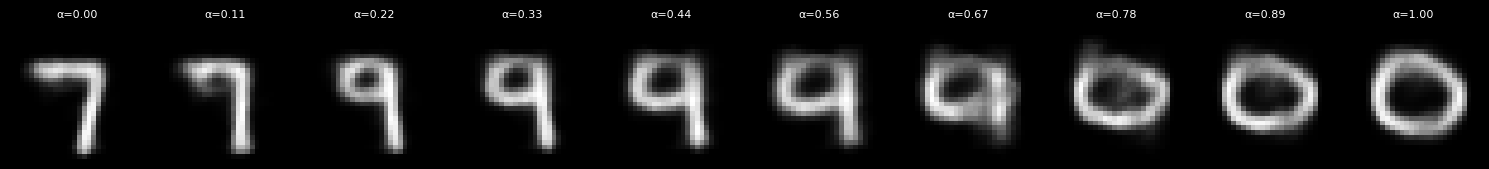

In [97]:
def interpolate_latent(model, z1, z2, num_steps=10):
    """
    Interpola entre dos puntos en el espacio latente
    
    Args:
        model: VAE entrenado
        z1, z2: vectores latentes de inicio y fin
        num_steps: número de pasos de interpolación
    """
    # Crear interpolación lineal
    alphas = np.linspace(0, 1, num_steps)
    interpolated = []
    
    for alpha in alphas:
        z = (1 - alpha) * z1 + alpha * z2
        img = model.decode(z).view(28, 28).detach().cpu().numpy()
        interpolated.append(img)
    
    # Visualizar
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps*1.5, 2))
    for i, (ax, img) in enumerate(zip(axes, interpolated)):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'α={alphas[i]:.2f}', fontsize=8)
    plt.tight_layout()
    plt.show()

# Obtener dos imágenes aleatorias del test set y sus códigos latentes
model.eval()
test_iter = iter(test_loader)
test_batch = next(test_iter)
x1 = test_batch[0][0:1].view(1, 784).to(DEVICE)
x2 = test_batch[0][5:6].view(1, 784).to(DEVICE)

# Codificar
with torch.no_grad():
    mean1, L1 = model.encode(x1)
    mean2, L2 = model.encode(x2)

# Interpolar entre las medias (usamos las medias, no muestreamos)
print("Interpolación entre dos dígitos del conjunto de test:")
interpolate_latent(model, mean1, mean2, num_steps=10)

# Interpolar entre puntos aleatorios del prior
print("\nInterpolación entre dos puntos aleatorios del prior N(0,I):")
z_random1 = torch.randn(1, model.latent_dim).to(DEVICE) * 2
z_random2 = torch.randn(1, model.latent_dim).to(DEVICE) * 2
interpolate_latent(model, z_random1, z_random2, num_steps=10)

## Análisis adicional: Visualización de la distribución latente aprendida

Veamos cómo se distribuyen realmente las imágenes del dataset en el espacio latente (solo funciona bien con latent_dim=2):

Distribución de códigos latentes del conjunto de test:


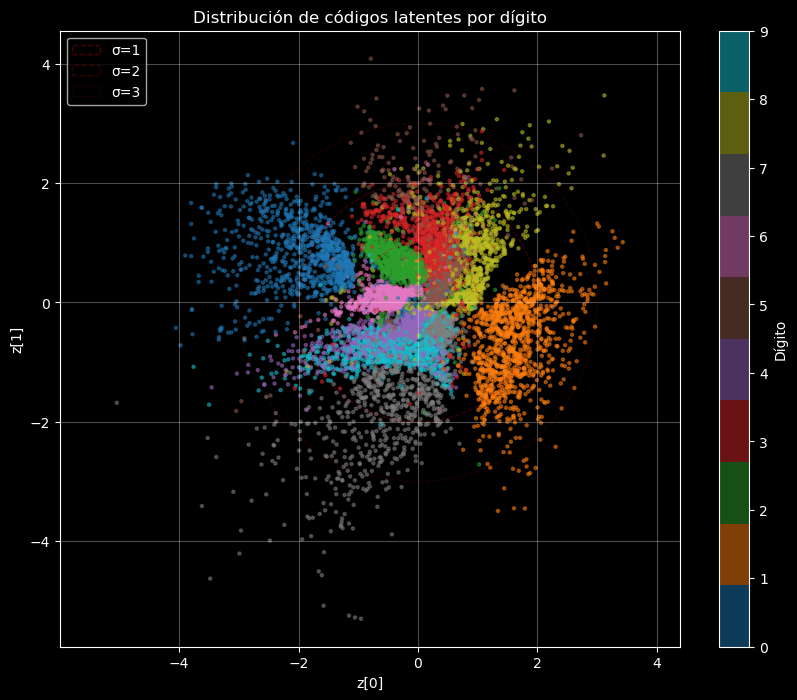

In [98]:
def plot_latent_distribution(model, data_loader, num_samples=5000):
    """
    Visualiza la distribución de los códigos latentes en 2D
    Solo funciona si latent_dim == 2
    """
    if model.latent_dim != 2:
        print(f"Esta visualización solo funciona con latent_dim=2, pero el modelo tiene latent_dim={model.latent_dim}")
        return
    
    model.eval()
    latent_codes = []
    labels_list = []
    
    with torch.no_grad():
        for batch_idx, (x, labels) in enumerate(data_loader):
            if len(latent_codes) * data_loader.batch_size >= num_samples:
                break
            
            x = x.view(-1, 784).to(DEVICE)
            mean, L = model.encode(x)
            latent_codes.append(mean.cpu().numpy())
            labels_list.append(labels.numpy())
    
    latent_codes = np.concatenate(latent_codes, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    
    # Plotear
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_codes[:, 0], latent_codes[:, 1], 
                         c=labels_list, cmap='tab10', alpha=0.5, s=5)
    plt.colorbar(scatter, label='Dígito')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.title('Distribución de códigos latentes por dígito')
    plt.grid(True, alpha=0.3)
    
    # Añadir círculos de referencia (desviaciones estándar del prior)
    circle1 = plt.Circle((0, 0), 1, color='red', fill=False, linestyle='--', alpha=0.3, label='σ=1')
    circle2 = plt.Circle((0, 0), 2, color='red', fill=False, linestyle='--', alpha=0.2, label='σ=2')
    circle3 = plt.Circle((0, 0), 3, color='red', fill=False, linestyle='--', alpha=0.1, label='σ=3')
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.legend()
    plt.axis('equal')
    plt.show()

print("Distribución de códigos latentes del conjunto de test:")
plot_latent_distribution(model, test_loader, num_samples=10000)

## Conclusiones finales

### Resumen de lo aprendido:

1. **Implementación VAE con covarianza completa:**
   - Usamos la descomposición de Cholesky para modelar matrices de covarianza completas
   - Esto permite capturar correlaciones entre dimensiones latentes
   - Es más expresivo que la covarianza diagonal pero tiene más parámetros

2. **Trade-offs importantes:**
   - **latent_dim**: balance entre compresión/visualización y calidad
   - **hidden_dim**: más neuronas → mejor capacidad pero más lento
   - **learning_rate**: afecta convergencia y estabilidad

3. **Rol de la KL-divergence:**
   - Regulariza el espacio latente hacia N(0,I)
   - Permite generación muestreando del prior
   - Previene overfitting y colapso del espacio latente

4. **Espacios latentes de alta dimensión:**
   - No podemos visualizar directamente con `plot_latent_space`
   - Usamos "slices" 2D o reducción de dimensionalidad
   - Mayor capacidad expresiva pero menos interpretable

5. **Propiedades del espacio latente:**
   - **Continuidad:** interpolaciones suaves entre puntos
   - **Clustering:** dígitos similares agrupados
   - **Estructura:** organización semántica emergente

### Próximos pasos para mejorar:

- Implementar β-VAE para controlar el trade-off reconstrucción/regularización
- Probar arquitecturas convolucionales (Conv-VAE) para mejor calidad
- Implementar VAE condicional (CVAE) para generación controlada por clase
- Experimentar con otros priors (VampPrior, normalizing flows)
- Usar métricas cuantitativas (FID, IS) para evaluar calidad generativa